# Demo of how the Simulation Database makes it easier to analyse a parameter sweep

(This requires chaste-simulation-database-connector module)  
Database of friction-presssure parameter sweep from blood vessel paper.  


Also a demo of the power of pandas dataframes when performing analysis (also why pandas dataframes are closely tied into module).  


In [1]:
import cell_movie_maker as cmm
import chaste_simulation_database_connector as csdc
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pathlib
from plotnine import *


from IPython.display import display
import IPython.display


cmm.Config.simulations_folder = pathlib.Path("chaste_output").resolve()
cmm.Config.output_folder = pathlib.Path("analysis_output").resolve()

experiment = "friction-pressure-parameter-sweep" # Store experiment as string instead of cmm.Experiment because raw data does not exist here (does not effect rest of the code)
cmm.Config.set_simulation_database(pathlib.Path("analysis_output", "friction-pressure-parameter-sweep.db"))


# Parameters

`VariedParams` flag is set correctly, therefore this retrieves only parameters which vary across the parameter sweep.  

In [2]:
parameters = cmm.Config.simulation_database.CollectorFactory(csdc.collectors.ParametersCollector).collect(experiment)
display(parameters)

parameter_name,ConfigurationSeed,FrictionStrength,Seed,VesselPressure
iteration,,,,
0,0,1.0,0,5.0
1,0,0.0,0,0.5
2,0,0.0,0,1.0
3,0,0.0,0,1.5
4,0,0.0,0,2.0
...,...,...,...,...
1756,4,5.0,3,3.0
1757,4,5.0,3,3.5
1758,4,5.0,3,4.0


Parameter grid for Seed = 0, ConfigurationSeed = 1

In [3]:
parameters.query("ConfigurationSeed==1 & Seed==0").reset_index().pivot(index='FrictionStrength', columns='VesselPressure', values='iteration')

VesselPressure,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
FrictionStrength,,,,,,,,,,
0.0,111,112,113,114,115,116,117,118,119,120
0.5,121,122,123,124,125,126,127,128,129,130
1.0,131,132,133,134,135,136,137,138,139,140
1.5,141,142,143,144,145,146,147,148,149,150
2.0,151,152,153,154,155,156,157,158,159,160
2.5,161,162,163,164,165,166,167,168,169,170
3.0,171,172,173,174,175,176,177,178,179,180
3.5,181,182,183,184,185,186,187,188,189,190
4.0,191,192,193,194,195,196,197,198,199,200


# Cellcounts

In [4]:
collector = cmm.Config.simulation_database.CollectorFactory(csdc.collectors.CellcountCollector)
cellcounts = collector.collect(experiment)
display(cellcounts.head(10))

100%|██████████| 1759/1759 [00:02<00:00, 641.08it/s]


n_tumour  n_tumour_hypoxic  n_tumour_necrotic  n_vessels  \
iteration timestep                                                             
0         0                4                 0                  0        401   
          600              4                 0                  0        401   
          1200             7                 0                  0        401   
          1800             7                 0                  0        401   
          2400             8                 0                  0        401   
          3000             8                 0                  0        401   
          3600             8                 0                  0        401   
          4200            13                 0                  0        401   
          4800            14                 0                  0        401   
          5400            15                 0                  0        401   

                    n_vessels_radius_ge95  n_vessels_radius_ge90  \
iteration timestep                                                 
0         0                           401                    401   
          600                         401                    401   
          1200                        401                    401   
          1800                        401                    401   
          2400                        401                    401   
          3000                        401                    401   
          3600                        401                    401   
          4200                        401                    401   
          4800                        401                    401   
          5400                        401                    401   

                    n_vessels_radius_ge70  mean_tumour_oxygen  \
iteration timestep                                              
0         0                           401            0.999493   
          600                         401            0.847373   
          1200                        401            0.761902   
          1800                        401            0.719452   
          2400                        401            0.700458   
          3000                        401            0.684058   
          3600                        401            0.676509   
          4200                        401            0.650057   
          4800                        401            0.634200   
          5400                        401            0.631798   

                    median_tumour_oxygen  mean_tumour_radius  \
iteration timestep                                             
0         0                     0.999490            0.392259   
          600                   0.847554            0.470798   
          1200                  0.752970            0.467410   
          1800                  0.708085            0.467410   
          2400                  0.692522            0.466353   
          3000                  0.676083            0.466749   
          3600                  0.668519            0.466749   
          4200                  0.638551            0.446320   
          4800                  0.621638            0.451599   
          5400                  0.615847            0.440905   

                    median_tumour_radius  
iteration timestep                        
0         0                     0.392259  
          600                   0.470798  
          1200                  0.465476  
          1800                  0.465476  
          2400                  0.469717  
          3000                  0.470796  
          3600                  0.470796  
          4200                  0.450240  
          4800                  0.457049  
          5400                  0.455327

Growth trajectory across parameter space

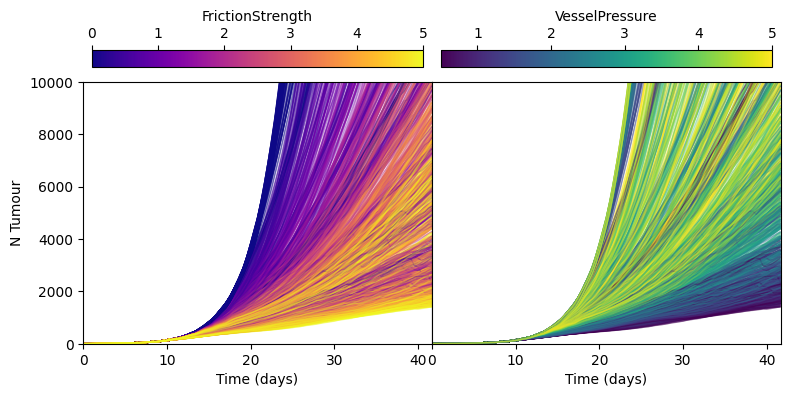

In [19]:
df = cellcounts.join(parameters).query('iteration>0').reset_index().groupby('iteration') # Iteration 0 is sample sim

fig, axs = plt.subplots(1,2, figsize=(9,4), gridspec_kw=dict(hspace=0, wspace=0))
for ax in axs:
    ax.set_ylim(0,10000)
    ax.set_xlim(0,60000/60/24)
    ax.set_xlabel('Time (days)')
axs[0].set_ylabel('N Tumour')
axs[1].set_yticks([])


ax = axs[0]
colour_param = 'FrictionStrength'
cmap = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(parameters[colour_param].min(), parameters[colour_param].max()), matplotlib.colormaps['plasma'])
lines = matplotlib.collections.LineCollection([np.column_stack((g.timestep/60/24, g.n_tumour)) for it, g in df], colors=cmap.to_rgba(df[colour_param].head(1)), linewidths=1, alpha=.4)
ax.add_collection(lines)
fig.colorbar(cmap, ax=ax, label=colour_param, location='top', shrink=.95, fraction=.1)

ax = axs[1]
colour_param = 'VesselPressure'
cmap = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(parameters[colour_param].min(), parameters[colour_param].max()), matplotlib.colormaps['viridis'])
lines = matplotlib.collections.LineCollection([np.column_stack((g.timestep/60/24, g.n_tumour)) for it, g in df], colors=cmap.to_rgba(df[colour_param].head(1)), linewidths=1, alpha=.4)
ax.add_collection(lines)
fig.colorbar(cmap, ax=ax, label=colour_param, location='top', shrink=.95, fraction=.1)

plt.show(fig)
plt.close(fig)

Size by some timepoint

In [ ]:
# Cellcounts at t=45000h or final timepoint if simulation ended earlier
t = 45000
df = cellcounts.join(parameters).query('iteration>0').reset_index().sort_values(['iteration', 'timestep'], ascending=[True, False]).query(f'timestep <= {t}').groupby('iteration').head(1) # iteration 0 is sample sim

# Calculate mean tumour count for each parameter set and reshape into image grid
avg_n_tumour = df.groupby(['FrictionStrength', 'VesselPressure']).n_tumour.mean().reset_index().pivot(index='FrictionStrength', columns='VesselPressure', values='n_tumour')

fig, ax = plt.subplots(1,1, figsize=(8,6))
cm = ax.imshow(avg_n_tumour, origin='lower', extent=[*avg_n_tumour.index[[0,-1]], *avg_n_tumour.columns[[0,-1]]], cmap='plasma')
ax.set_ylabel('Friction Strength')
ax.set_xlabel('Vessel Pressure')
fig.colorbar(cm, label=f'N Tumour at t={t/60/24:.1f}')
plt.show(fig, plt.close(fig))

# Tumour-Vessel Pair Correlation Functions

In [7]:
collector = cmm.Config.simulation_database.CollectorFactory(csdc.collectors.PCFCollector)
pcfs = collector.collect(experiment, 'Tumour-Vessel PCF 50') # Provide analysis name manually (Legacy database had different naming convention)
display(pcfs.head(10))

100%|██████████| 1759/1759 [00:01<00:00, 1020.11it/s]


,r,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
iteration,timestep,,,,,,,,,,,,,,,,,,,,,
0,42327,1.201466,1.414924,1.388769,1.337762,1.305269,1.280220,1.246087,1.223702,1.203442,1.183268,...,1.013562,1.012419,1.009303,1.003350,1.003079,0.997782,0.992419,0.989108,0.990585,0.987930
1,55124,0.576979,0.737672,0.745897,0.735166,0.748575,0.758445,0.770902,0.782589,0.795244,0.806651,...,0.901569,0.907384,0.904504,0.908790,0.919448,0.920819,0.927422,0.931075,0.944591,0.946458
2,39455,0.646787,0.924260,0.889421,0.893908,0.894899,0.888930,0.889668,0.889027,0.899214,0.893838,...,0.996348,0.998616,0.997110,1.000892,1.008612,1.007629,1.014716,1.013807,1.021685,1.025251
3,36570,0.597411,1.009745,0.956118,0.955981,0.962835,0.954403,0.954531,0.954092,0.962412,0.954292,...,1.012838,1.017676,1.015170,1.013965,1.020849,1.018734,1.023163,1.020827,1.024861,1.030559
4,35584,0.624201,1.113465,1.068160,1.069327,1.068006,1.052946,1.058345,1.055884,1.058443,1.055556,...,1.000448,1.003266,0.993806,0.993496,0.990603,0.990736,0.990585,0.986484,0.987962,0.993029
5,34996,0.599515,1.111130,1.068542,1.067395,1.068989,1.055046,1.056504,1.056080,1.061527,1.049321,...,0.997927,0.998470,0.994433,0.987461,0.993296,0.986994,0.989630,0.986873,0.991953,0.996488
6,34812,0.526879,1.072333,1.051947,1.043876,1.040863,1.028688,1.032949,1.033272,1.033519,1.028677,...,1.004135,1.003441,0.999040,0.996846,0.999758,0.997627,0.992457,0.996881,1.001646,1.002466
7,34607,0.484680,1.090792,1.058900,1.052751,1.048561,1.047021,1.049944,1.045998,1.048946,1.040843,...,1.003712,1.002675,0.996476,0.993477,0.995608,0.989768,0.991011,0.991382,0.997809,0.997335
8,34529,0.467790,1.073568,1.071606,1.057823,1.053866,1.045997,1.046387,1.050080,1.047530,1.040096,...,1.004166,1.002850,0.995724,0.994985,0.995058,0.992128,0.991285,0.990413,0.998413,0.999660


Plot PCFs

Text(0, 0.5, 'Tumour-Vessel g(r)')

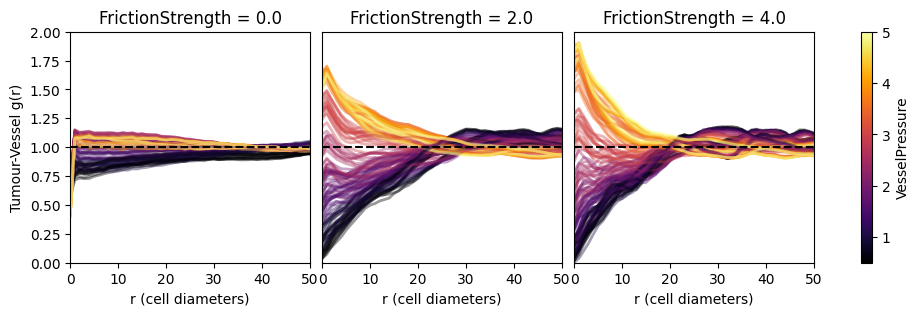

In [17]:
df = pcfs.join(parameters).query('iteration>0') # Iteration 0 is sample sim

cmap = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(parameters['VesselPressure'].min(), parameters['VesselPressure'].max()), matplotlib.colormaps['inferno'])

fig, axs = plt.subplots(1,3, figsize=(12,3), gridspec_kw=dict(hspace=0, wspace=0.05))
for ax, friction_strength in zip(axs, df.FrictionStrength.unique()[::4]):
    _df = df.loc[df.FrictionStrength==friction_strength, pcfs.columns]
    lines = matplotlib.collections.LineCollection([np.column_stack((pcfs.columns, r)) for _, r in _df.iterrows()], colors=cmap.to_rgba(parameters.loc[_df.index.get_level_values('iteration'), 'VesselPressure']), alpha=.4, linewidth=2)
    ax.add_collection(lines)
    ax.axhline(1, linestyle='dashed', color='black')
    ax.set_xlim(0,50)
    ax.set_ylim(0,2)
    ax.set_title(f'FrictionStrength = {friction_strength}')
    ax.set_xlabel('r (cell diameters)')
for ax in axs[1:]:
    ax.set_yticks([])
fig.colorbar(cmap, ax=axs.ravel(), label='VesselPressure')
axs[0].set_ylabel('Tumour-Vessel g(r)')